In [15]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import sklearn.neighbors as knn
import and_logic_generator as and_gen
import utils
import applicability_domain as ad
import adversarial_generator as adversarial

# reload modules every 2 seconds
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:


class AndGatePipeline:
    def __init__(self, x, y, random_state=None):
        self.x = x
        self.y = y
        if random_state is not None:
            self.random_state = random_state

    @property
    def x(self):
        return self.__x

    @x.setter
    def x(self, x):
        self.__x = x

    @property
    def y(self):
        return self.__y

    @y.setter
    def y(self, y):
        self.__y = y

    @property
    def random_state(self):
        return self.__random_state

    @random_state.setter
    def random_state(self, random_state):
        self.__random_state = random_state

    def plot_data(self, figsize=None, xlim=None, ylim=None):
        x = self.x
        y = self.y

        if figsize is not None:
            plt.figure(figsize=figsize.tolist())

        plt.scatter(
            x[:, 0], x[:, 1], marker='.', c=y, alpha=0.8, cmap='coolwarm',
            s=8, edgecolor='face')
        plt.grid(False)
        plt.title('Samples with true labels')

        if xlim is not None:
            plt.xlim(xlim[0], xlim[1])
        if ylim is not None:
            plt.ylim(ylim[0], ylim[1])

        plt.show()

    def train_test_split(self, test_size=0.2):
        print(f'Train test split: {(1-test_size):.2f}:{test_size:.2f}')
        x_train, x_test, y_train, y_test = train_test_split(
            x, y, test_size=test_size)
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test

    def fit_svm_model(self, gamma, C, x_norms=None, shift=None, verbose=1):
        random_state = self.random_state

        self.model = svm.SVC(
            kernel='rbf', random_state=random_state, gamma=gamma, C=C)
        self.model.fit(self.x_train, self.y_train)

        self.pred_train = self.model.predict(self.x_train)
        score_train = accuracy_score(self.y_train, self.pred_train)

        self.pred_test = self.model.predict(self.x_test)
        score_test = accuracy_score(self.y_test, self.pred_test)

        if verbose == 1:
            print(f'With gamma = {gamma} and C = {C}')
            print(f'Accuracy on train set = {score_train*100:.4f}%')
            print(f'Accuracy on test set  = {score_test*100:.4f}%')

        x_basis, y_basis = and_gen.get_basic_set(shift=shift, norms=x_norms)
        utils.run_basic_test(x_basis, y_basis, self.model)

    def plot_prediction(
            self, figsize, h, mesh_xlim, mesh_ylim, xlim, ylim):
        xx, yy = np.meshgrid(
            np.arange(mesh_xlim[0], mesh_xlim[1], h),
            np.arange(mesh_ylim[0], mesh_ylim[1], h))
        x_mesh = np.c_[xx.ravel(), yy.ravel()]
        Z = self.model.predict(x_mesh)
        Z = Z.reshape(xx.shape)

        plt.figure(figsize=figsize.tolist())
        plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.6)
        plt.scatter(
            self.x_test[:, 0], self.x_test[:, 1], c=self.y_test,
            marker='.', alpha=0.8, cmap='coolwarm', s=8, edgecolor='face')
        plt.xlim(xlim[0], xlim[1])
        plt.ylim(ylim[0], ylim[1])
        plt.title('Decision boundary on the test set')
        plt.show()

    def generate_adversarial_examples(self, epsilon):
        ind_train_c0 = np.where(self.y_train == 0)
        x_train_c0 = self.x_train[ind_train_c0]
        y_train_c0 = np.zeros(len(x_train_c0))
        mu_train_c0 = np.mean(x_train_c0, axis=0)

        ind_train_c1 = np.where(self.y_train == 1)
        x_train_c1 = self.x_train[ind_train_c1]
        y_train_c1 = np.ones(len(x_train_c1))
        mu_train_c1 = np.mean(x_train_c1, axis=0)

        print(f'Negative mean = [{mu_train_c0[0]:.4f}, {mu_train_c0[1]:.4f}]')
        print(f'Positive mean = [{mu_train_c1[0]:.4f}, {mu_train_c1[1]:.4f}]')

        adversarial_examples = np.copy(self.x_test)
        pred = self.pred_test
        targets = and_gen.get_not_y(self.y_test)

        epoch = 1
        while np.array_equal(pred, targets) == False:
            adversarial_examples = adversarial.moving_mean(
                x=adversarial_examples,
                y=pred,
                targets=targets,
                means={0: mu_train_c0, 1: mu_train_c1},
                epsilon=epsilon,
                verbose=0,
                epoch=epoch)
            pred = self.model.predict(adversarial_examples)
            epoch += 1

        print(f'Completed after {epoch} epoch...')
        self.adversarial_examples = adversarial_examples

        original_pred = self.model.predict(self.x_test)
        self.pred_ae = self.model.predict(adversarial_examples)
        self.y_ae = and_gen.get_y(adversarial_examples)

        matches = np.equal(self.y_ae, self.pred_ae)
        ind_misclassified = np.where(matches == False)[0]

        missclassified = len(ind_misclassified)
        print(f'Misclassified = {missclassified}')

        pred_miss = self.pred_ae[ind_misclassified]
        false_neg = len(pred_miss[pred_miss == 0])
        false_pos = len(pred_miss[pred_miss == 1])
        print(f'Misclassified negative = {false_neg} ({false_neg/len(self.y_ae)*100:.4f}%)')
        print(f'Misclassified positive = {false_pos} ({false_pos/len(self.y_ae)*100:.4f}%)')

        count = len(matches[matches == False])
        print(f'Found {len(ind_misclassified)} Adversarial Examples out of '
              + f'{len(self.y_ae)}. {len(ind_misclassified) / len(self.y_ae) * 100.0:.4f}% '
              + 'successful rate')

    def plot_adversarial_examples(
            self, figsize, h, mesh_xlim, mesh_ylim, xlim, ylim):
        xx, yy = np.meshgrid(
            np.arange(mesh_xlim[0], mesh_xlim[1], h),
            np.arange(mesh_ylim[0], mesh_ylim[1], h))
        x_mesh = np.c_[xx.ravel(), yy.ravel()]
        Z = self.model.predict(x_mesh)
        Z = Z.reshape(xx.shape)

        plt.figure(figsize=figsize.tolist())
        plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.6)
        plt.scatter(
            self.adversarial_examples[:, 0], self.adversarial_examples[:, 1],
            c=self.pred_ae, marker='.', alpha=0.8, 
            cmap='coolwarm', s=8, edgecolor='face')
        plt.xlim(xlim[0], xlim[1])
        plt.ylim(ylim[0], ylim[1])
        plt.title('Generated Adversarial Examples')
        plt.show()

    def run_applicability_domain(self, zeta0, zeta1, k=9, verbose=1):
        x_ae = self.adversarial_examples

        # Applicability Domain
        # Stage 1 - Applicability
        print('\n---------- Applicability ---------------')
        x_passed_s1, ind_passed_s1 = ad.check_applicability(
            x_ae, self.x_train, self.y_train)
        pred_passed_s1 = self.pred_ae[ind_passed_s1]

        # Print
        pass_rate = utils.get_rate(x_passed_s1, x_ae)
        print(f'Pass rate = {pass_rate * 100:.4f}%')

        # Stage 2 - Reliability
        print('\n---------- Reliability -----------------')
        # Creating kNN models for each class
        ind_train_c0 = np.where(self.y_train == 0)
        model_knn_c0 = utils.unimodal_knn(self.x_train[ind_train_c0], k)

        ind_train_c1 = np.where(self.y_train == 1)
        model_knn_c1 = utils.unimodal_knn(self.x_train[ind_train_c1], k)

        # Computing mean, standard deviation and threshold
        mu_c0, sd_c0 = utils.get_distance_info(
            model_knn_c0, self.x_train[ind_train_c0], k, seen_in_train_set=True)
        threshold_c0 = ad.get_reliability_threshold(mu_c0, sd_c0, zeta0)

        mu_c1, sd_c1 = utils.get_distance_info(
            model_knn_c1, self.x_train[ind_train_c1], k, seen_in_train_set=True)
        threshold_c1 = ad.get_reliability_threshold(mu_c1, sd_c1, zeta1)

        x_passed_s2, ind_passed_s2 = ad.check_reliability(
            x_passed_s1,
            predictions=pred_passed_s1,
            models=[model_knn_c0, model_knn_c1],
            dist_thresholds=[threshold_c0, threshold_c1],
            classes=[0, 1],
            verbose=verbose
        )
        pred_passed_s2 = pred_passed_s1[ind_passed_s2]

        # Print
        print('Distance of c0 in training set:')
        print('{:18s} = {:.4f}'.format('Mean', mu_c0))
        print('{:18s} = {:.4f}'.format('Standard deviation', sd_c0))
        print('{:18s} = {:.4f}\n'.format('Threshold', threshold_c0))

        print('Distance of c1 in training set:')
        print('{:18s} = {:.4f}'.format('Mean', mu_c1))
        print('{:18s} = {:.4f}'.format('Standard deviation', sd_c1))
        print('{:18s} = {:.4f}\n'.format('Threshold', threshold_c1))

        pass_rate = utils.get_rate(x_passed_s2, x_passed_s1)
        print(f'Pass rate = {pass_rate * 100:.4f}%')

        # Stage 3 - Decidability
        print('\n---------- Decidability ----------------')        
        model_knn = knn.KNeighborsClassifier(
            n_neighbors=k, n_jobs=-1, weights='distance')
        model_knn.fit(self.x_train, self.y_train)

        x_passed_s3, ind_passed_s3 = ad.check_decidability(
            x_passed_s2, pred_passed_s2, model_knn)

        # Print
        pass_rate = utils.get_rate(x_passed_s3, x_passed_s2)
        print(f'Pass rate = {pass_rate * 100:.4f}%')

        self.x_passed_ad = x_passed_s3
        self.y_passed_ad = and_gen.get_y(x_passed_s3)

        # Results
        print('\n---------- Results ---------------------')
        score = accuracy_score(self.y_ae, self.pred_ae)
        print(f'Accuracy before AD = {score*100:.4f}%')
        print()

        pass_rate = utils.get_rate(x_passed_s3, x_ae)
        y_passed = and_gen.get_y(x_passed_s3)
        pred_after_ad = self.model.predict(x_passed_s3)
        score = accuracy_score(y_passed, pred_after_ad)
        matches = np.equal(y_passed, pred_after_ad)
        self.ind_misclassified = np.where(matches == False)[0]

        print(f'Overall pass rate = {pass_rate * 100:.4f}%')
        print(f'Accuracy after AD = {score*100:.4f}%')
        print(f'{len(x_passed_s3)} out of {len(x_ae)}\n')

        missclassified = len(self.ind_misclassified)
        print(f'Misclassified = {missclassified}')

        pred_miss = pred_after_ad[self.ind_misclassified]
        false_neg = len(pred_miss[pred_miss==0])
        false_pos = len(pred_miss[pred_miss==1])
        print(f'Misclassified negative = {false_neg} ({false_neg/len(y_passed)*100:.4f}%)')
        print(f'Misclassified positive = {false_pos} ({false_pos/len(y_passed)*100:.4f}%)')
    
    def plot_after_ad(self, figsize, h, mesh_xlim, mesh_ylim, xlim, ylim):
        xx, yy = np.meshgrid(
            np.arange(mesh_xlim[0], mesh_xlim[1], h),
            np.arange(mesh_ylim[0], mesh_ylim[1], h))
        x_mesh = np.c_[xx.ravel(), yy.ravel()]
        Z = self.model.predict(x_mesh)
        Z = Z.reshape(xx.shape)

        plt.figure(figsize=figsize.tolist())
        plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.6)

        x_miss = self.x_passed_ad[self.ind_misclassified]
        y_miss = self.y_passed_ad[self.ind_misclassified]
        plt.scatter(
            x_miss[:, 0], x_miss[:, 1],
            c=y_miss, marker='.', alpha=0.8, 
            cmap='coolwarm', s=8, edgecolor='face')
        plt.xlim(xlim[0], xlim[1])
        plt.ylim(ylim[0], ylim[1])
        plt.title('Missclassified samples after AD')
        plt.show()



In [17]:
# Repeatable seed
random_state = 2**12
np.random.seed(seed=random_state)


In [18]:
# Prepare samples
n = 2000
scale = 0.06  # control how spread the blob is.
centres = [
    [0.25, 0.25],
    [0.75, 0.25],
    [0.25, 0.75],
    [0.75, 0.75]]

x = np.array([], dtype=np.float32)
y = np.array([], dtype=np.int)
for centre in centres:
    temp_x, temp_y = and_gen.generate_logistic_samples(
        n=int(n / len(centres)), threshold=0.5, centre=centre, scale=scale)
    # numpy append func does NOT allow preallocate multi-dimensional array
    if len(x) == 0:
        x = temp_x
    else:
        x = np.append(x, temp_x, axis=0)
    y = np.append(y, temp_y)
x = x - 0.5
shift = [[-0.5, -0.5]]

# Parameters for Figure 1
figsize = np.array(plt.rcParams["figure.figsize"]) * 2
x_max = np.amax(x, axis=0) * 1.1
x_min = np.amin(x, axis=0) * 1.1

# Parameters for SVM
gamma='scale'
C=100

# Parameters for Applicability Domain
k = 9
zeta0 = 2.2
zeta1 = 1.2


In [19]:
and_gate_pipeline = AndGatePipeline(x, y)
and_gate_pipeline.random_state = random_state


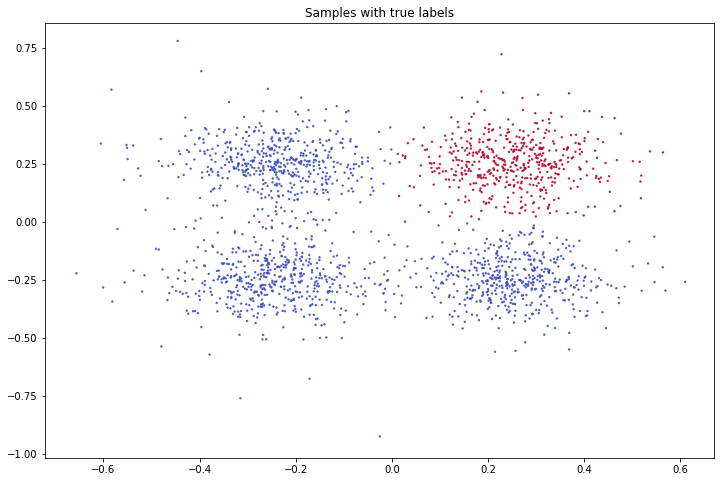

In [20]:
and_gate_pipeline.plot_data(
    figsize=figsize, xlim=[x_min[0], x_max[0]], ylim=[x_min[1], x_max[1]])


In [21]:
# 80:20 split on training and test sets
and_gate_pipeline.train_test_split(0.2)

Train test split: 0.80:0.20


In [22]:
and_gate_pipeline.fit_svm_model(gamma=gamma, C=C, shift=shift)


With gamma = scale and C = 100
Accuracy on train set = 100.0000%
Accuracy on test set  = 99.7500%
Passed basic test


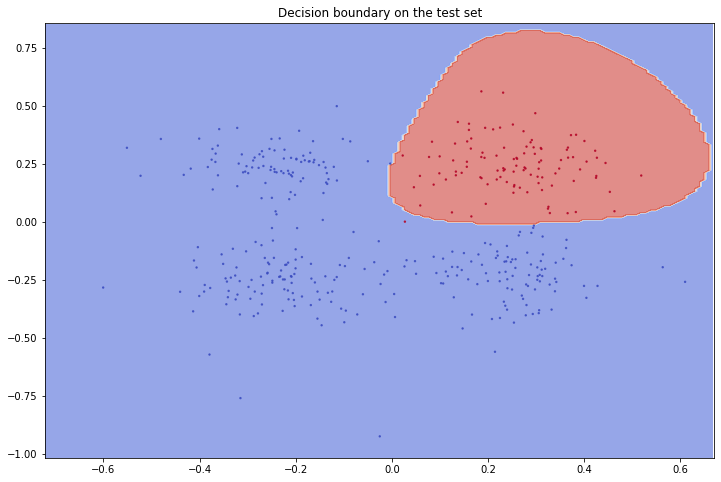

In [23]:
and_gate_pipeline.plot_prediction(
    figsize, h=0.01, 
    mesh_xlim=[x_min[0], x_max[0]], mesh_ylim=[x_min[1], x_max[1]], 
    xlim=[x_min[0], x_max[0]], ylim=[x_min[1], x_max[1]])


In [24]:
and_gate_pipeline.model.get_params()


{'C': 100,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 4096,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [25]:
and_gate_pipeline.generate_adversarial_examples(epsilon=0.0006)


Negative mean = [-0.0848, -0.0740]
Positive mean = [0.2498, 0.2561]
Completed after 1527 epoch...
Misclassified = 292
Misclassified negative = 66 (16.5000%)
Misclassified positive = 226 (56.5000%)
Found 292 Adversarial Examples out of 400. 73.0000% successful rate


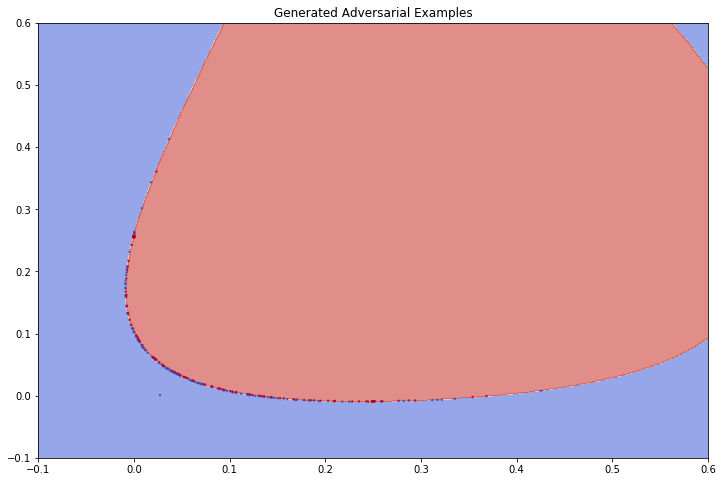

In [26]:
and_gate_pipeline.plot_adversarial_examples(
    figsize, h=0.001,
    mesh_xlim=[-0.1, 0.6], mesh_ylim=[-0.1, 0.6],
    xlim=[-0.1, 0.6], ylim=[-0.1, 0.6])


In [27]:
and_gate_pipeline.run_applicability_domain(zeta0=zeta0, zeta1=zeta1, k=k)



---------- Applicability ---------------
Pass rate = 100.0000%

---------- Reliability -----------------

In 0 class:
Threshold = 0.0758
Average mean = 0.0841
Passed indices:
5, 7, 29, 42, 44, 54, 55, 61, 77, 79, 86, 92, 96, 115, 126, 132, 134, 136, 161, 164, 176, 188, 190, 197, 199, 214, 222, 237, 255, 281, 287, 288, 310, 332, 333, 339, 346, 347, 352, 353, 365, 371, 379, 394

In 1 class:
Threshold = 0.0526
Average mean = 0.0696
Passed indices:

Distance of c0 in training set:
Mean               = 0.0281
Standard deviation = 0.0217
Threshold          = 0.0758

Distance of c1 in training set:
Mean               = 0.0281
Standard deviation = 0.0205
Threshold          = 0.0526

Pass rate = 11.0000%

---------- Decidability ----------------
Pass rate = 88.6364%

---------- Results ---------------------
Accuracy before AD = 27.0000%

Overall pass rate = 9.7500%
Accuracy after AD = 100.0000%
39 out of 400

Misclassified = 0
Misclassified negative = 0 (0.0000%)
Misclassified positive = 0 (0.

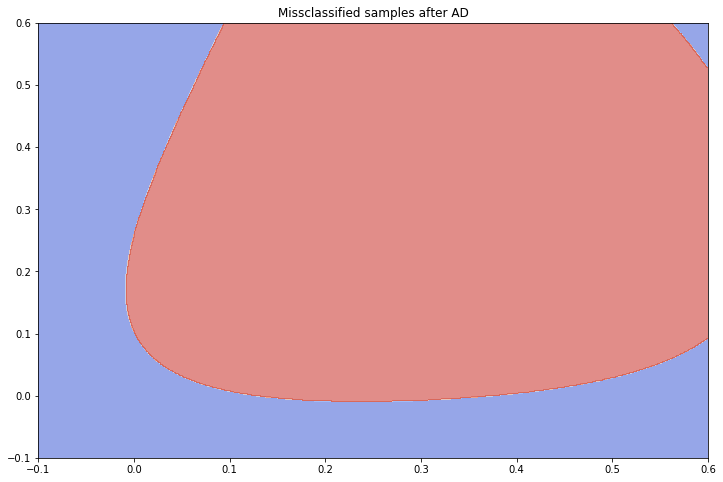

In [28]:
and_gate_pipeline.plot_after_ad(
    figsize, h=0.001,
    mesh_xlim=[-0.1, 0.6], mesh_ylim=[-0.1, 0.6],
    xlim=[-0.1, 0.6], ylim=[-0.1, 0.6])


In [29]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import sklearn.neighbors as knn
import and_logic_generator as and_gen
import utils
import applicability_domain as ad
import adversarial_generator as adversarial

# reload modules every 2 seconds
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:


class AndGatePipeline:
    def __init__(self, x, y, random_state=None):
        self.x = x
        self.y = y
        if random_state is not None:
            self.random_state = random_state

    @property
    def x(self):
        return self.__x

    @x.setter
    def x(self, x):
        self.__x = x

    @property
    def y(self):
        return self.__y

    @y.setter
    def y(self, y):
        self.__y = y

    @property
    def random_state(self):
        return self.__random_state

    @random_state.setter
    def random_state(self, random_state):
        self.__random_state = random_state

    def plot_data(self, figsize=None, xlim=None, ylim=None):
        x = self.x
        y = self.y

        if figsize is not None:
            plt.figure(figsize=figsize.tolist())

        plt.scatter(
            x[:, 0], x[:, 1], marker='.', c=y, alpha=0.8, cmap='coolwarm',
            s=8, edgecolor='face')
        plt.grid(False)
        plt.title('Samples with true labels')

        if xlim is not None:
            plt.xlim(xlim[0], xlim[1])
        if ylim is not None:
            plt.ylim(ylim[0], ylim[1])

        plt.show()

    def train_test_split(self, test_size=0.2):
        print(f'Train test split: {(1-test_size):.2f}:{test_size:.2f}')
        x_train, x_test, y_train, y_test = train_test_split(
            x, y, test_size=test_size)
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test

    def fit_svm_model(self, gamma, C, x_norms=None, shift=None, verbose=1):
        random_state = self.random_state

        self.model = svm.SVC(
            kernel='rbf', random_state=random_state, gamma=gamma, C=C)
        self.model.fit(self.x_train, self.y_train)

        self.pred_train = self.model.predict(self.x_train)
        score_train = accuracy_score(self.y_train, self.pred_train)

        self.pred_test = self.model.predict(self.x_test)
        score_test = accuracy_score(self.y_test, self.pred_test)

        if verbose == 1:
            print(f'With gamma = {gamma} and C = {C}')
            print(f'Accuracy on train set = {score_train*100:.4f}%')
            print(f'Accuracy on test set  = {score_test*100:.4f}%')

        x_basis, y_basis = and_gen.get_basic_set(shift=shift, norms=x_norms)
        utils.run_basic_test(x_basis, y_basis, self.model)

    def plot_prediction(
            self, figsize, h, mesh_xlim, mesh_ylim, xlim, ylim):
        xx, yy = np.meshgrid(
            np.arange(mesh_xlim[0], mesh_xlim[1], h),
            np.arange(mesh_ylim[0], mesh_ylim[1], h))
        x_mesh = np.c_[xx.ravel(), yy.ravel()]
        Z = self.model.predict(x_mesh)
        Z = Z.reshape(xx.shape)

        plt.figure(figsize=figsize.tolist())
        plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.6)
        plt.scatter(
            self.x_test[:, 0], self.x_test[:, 1], c=self.y_test,
            marker='.', alpha=0.8, cmap='coolwarm', s=8, edgecolor='face')
        plt.xlim(xlim[0], xlim[1])
        plt.ylim(ylim[0], ylim[1])
        plt.title('Decision boundary on the test set')
        plt.show()

    def generate_adversarial_examples(self, epsilon):
        ind_train_c0 = np.where(self.y_train == 0)
        x_train_c0 = self.x_train[ind_train_c0]
        y_train_c0 = np.zeros(len(x_train_c0))
        mu_train_c0 = np.mean(x_train_c0, axis=0)

        ind_train_c1 = np.where(self.y_train == 1)
        x_train_c1 = self.x_train[ind_train_c1]
        y_train_c1 = np.ones(len(x_train_c1))
        mu_train_c1 = np.mean(x_train_c1, axis=0)

        print(f'Negative mean = [{mu_train_c0[0]:.4f}, {mu_train_c0[1]:.4f}]')
        print(f'Positive mean = [{mu_train_c1[0]:.4f}, {mu_train_c1[1]:.4f}]')

        adversarial_examples = np.copy(self.x_test)
        pred = self.pred_test
        targets = and_gen.get_not_y(self.y_test)

        epoch = 1
        while np.array_equal(pred, targets) == False:
            adversarial_examples = adversarial.moving_mean(
                x=adversarial_examples,
                y=pred,
                targets=targets,
                means={0: mu_train_c0, 1: mu_train_c1},
                epsilon=epsilon,
                verbose=0,
                epoch=epoch)
            pred = self.model.predict(adversarial_examples)
            epoch += 1

        print(f'Completed after {epoch} epoch...')
        self.adversarial_examples = adversarial_examples

        original_pred = self.model.predict(self.x_test)
        self.pred_ae = self.model.predict(adversarial_examples)
        self.y_ae = and_gen.get_y(adversarial_examples)

        matches = np.equal(self.y_ae, self.pred_ae)
        ind_misclassified = np.where(matches == False)[0]

        missclassified = len(ind_misclassified)
        print(f'Misclassified = {missclassified}')

        pred_miss = self.pred_ae[ind_misclassified]
        false_neg = len(pred_miss[pred_miss == 0])
        false_pos = len(pred_miss[pred_miss == 1])
        print(f'Misclassified negative = {false_neg} ({false_neg/len(self.y_ae)*100:.4f}%)')
        print(f'Misclassified positive = {false_pos} ({false_pos/len(self.y_ae)*100:.4f}%)')

        count = len(matches[matches == False])
        print(f'Found {len(ind_misclassified)} Adversarial Examples out of '
              + f'{len(self.y_ae)}. {len(ind_misclassified) / len(self.y_ae) * 100.0:.4f}% '
              + 'successful rate')

    def plot_adversarial_examples(
            self, figsize, h, mesh_xlim, mesh_ylim, xlim, ylim):
        xx, yy = np.meshgrid(
            np.arange(mesh_xlim[0], mesh_xlim[1], h),
            np.arange(mesh_ylim[0], mesh_ylim[1], h))
        x_mesh = np.c_[xx.ravel(), yy.ravel()]
        Z = self.model.predict(x_mesh)
        Z = Z.reshape(xx.shape)

        plt.figure(figsize=figsize.tolist())
        plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.6)
        plt.scatter(
            self.adversarial_examples[:, 0], self.adversarial_examples[:, 1],
            c=self.pred_ae, marker='.', alpha=0.8, 
            cmap='coolwarm', s=8, edgecolor='face')
        plt.xlim(xlim[0], xlim[1])
        plt.ylim(ylim[0], ylim[1])
        plt.title('Generated Adversarial Examples')
        plt.show()

    def run_applicability_domain(self, zeta0, zeta1, k=9, verbose=1):
        x_ae = self.adversarial_examples

        # Applicability Domain
        # Stage 1 - Applicability
        print('\n---------- Applicability ---------------')
        x_passed_s1, ind_passed_s1 = ad.check_applicability(
            x_ae, self.x_train, self.y_train)
        pred_passed_s1 = self.pred_ae[ind_passed_s1]

        # Print
        pass_rate = utils.get_rate(x_passed_s1, x_ae)
        print(f'Pass rate = {pass_rate * 100:.4f}%')

        # Stage 2 - Reliability
        print('\n---------- Reliability -----------------')
        # Creating kNN models for each class
        ind_train_c0 = np.where(self.y_train == 0)
        model_knn_c0 = utils.unimodal_knn(self.x_train[ind_train_c0], k)

        ind_train_c1 = np.where(self.y_train == 1)
        model_knn_c1 = utils.unimodal_knn(self.x_train[ind_train_c1], k)

        # Computing mean, standard deviation and threshold
        mu_c0, sd_c0 = utils.get_distance_info(
            model_knn_c0, self.x_train[ind_train_c0], k, seen_in_train_set=True)
        threshold_c0 = ad.get_reliability_threshold(mu_c0, sd_c0, zeta0)

        mu_c1, sd_c1 = utils.get_distance_info(
            model_knn_c1, self.x_train[ind_train_c1], k, seen_in_train_set=True)
        threshold_c1 = ad.get_reliability_threshold(mu_c1, sd_c1, zeta1)

        x_passed_s2, ind_passed_s2 = ad.check_reliability(
            x_passed_s1,
            predictions=pred_passed_s1,
            models=[model_knn_c0, model_knn_c1],
            dist_thresholds=[threshold_c0, threshold_c1],
            classes=[0, 1],
            verbose=verbose
        )
        pred_passed_s2 = pred_passed_s1[ind_passed_s2]

        # Print
        print('Distance of c0 in training set:')
        print('{:18s} = {:.4f}'.format('Mean', mu_c0))
        print('{:18s} = {:.4f}'.format('Standard deviation', sd_c0))
        print('{:18s} = {:.4f}\n'.format('Threshold', threshold_c0))

        print('Distance of c1 in training set:')
        print('{:18s} = {:.4f}'.format('Mean', mu_c1))
        print('{:18s} = {:.4f}'.format('Standard deviation', sd_c1))
        print('{:18s} = {:.4f}\n'.format('Threshold', threshold_c1))

        pass_rate = utils.get_rate(x_passed_s2, x_passed_s1)
        print(f'Pass rate = {pass_rate * 100:.4f}%')

        # Stage 3 - Decidability
        print('\n---------- Decidability ----------------')        
        model_knn = knn.KNeighborsClassifier(
            n_neighbors=k, n_jobs=-1, weights='distance')
        model_knn.fit(self.x_train, self.y_train)

        x_passed_s3, ind_passed_s3 = ad.check_decidability(
            x_passed_s2, pred_passed_s2, model_knn)

        # Print
        pass_rate = utils.get_rate(x_passed_s3, x_passed_s2)
        print(f'Pass rate = {pass_rate * 100:.4f}%')

        self.x_passed_ad = x_passed_s3
        self.y_passed_ad = and_gen.get_y(x_passed_s3)

        # Results
        print('\n---------- Results ---------------------')
        score = accuracy_score(self.y_ae, self.pred_ae)
        print(f'Accuracy before AD = {score*100:.4f}%')
        print()

        pass_rate = utils.get_rate(x_passed_s3, x_ae)
        y_passed = and_gen.get_y(x_passed_s3)
        pred_after_ad = self.model.predict(x_passed_s3)
        score = accuracy_score(y_passed, pred_after_ad)
        matches = np.equal(y_passed, pred_after_ad)
        self.ind_misclassified = np.where(matches == False)[0]

        print(f'Overall pass rate = {pass_rate * 100:.4f}%')
        print(f'Accuracy after AD = {score*100:.4f}%')
        print(f'{len(x_passed_s3)} out of {len(x_ae)}\n')

        missclassified = len(self.ind_misclassified)
        print(f'Misclassified = {missclassified}')

        pred_miss = pred_after_ad[self.ind_misclassified]
        false_neg = len(pred_miss[pred_miss==0])
        false_pos = len(pred_miss[pred_miss==1])
        print(f'Misclassified negative = {false_neg} ({false_neg/len(y_passed)*100:.4f}%)')
        print(f'Misclassified positive = {false_pos} ({false_pos/len(y_passed)*100:.4f}%)')
    
    def plot_after_ad(self, figsize, h, mesh_xlim, mesh_ylim, xlim, ylim):
        xx, yy = np.meshgrid(
            np.arange(mesh_xlim[0], mesh_xlim[1], h),
            np.arange(mesh_ylim[0], mesh_ylim[1], h))
        x_mesh = np.c_[xx.ravel(), yy.ravel()]
        Z = self.model.predict(x_mesh)
        Z = Z.reshape(xx.shape)

        plt.figure(figsize=figsize.tolist())
        plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.6)

        x_miss = self.x_passed_ad[self.ind_misclassified]
        y_miss = self.y_passed_ad[self.ind_misclassified]
        plt.scatter(
            x_miss[:, 0], x_miss[:, 1],
            c=y_miss, marker='.', alpha=0.8, 
            cmap='coolwarm', s=8, edgecolor='face')
        plt.xlim(xlim[0], xlim[1])
        plt.ylim(ylim[0], ylim[1])
        plt.title('Missclassified samples after AD')
        plt.show()



In [31]:
# Repeatable seed
random_state = 2**12
np.random.seed(seed=random_state)


In [32]:
# Prepare samples
n = 2000
scale = 0.06  # control how spread the blob is.
centres = [
    [0.25, 0.25],
    [0.75, 0.25],
    [0.25, 0.75],
    [0.75, 0.75]]

x = np.array([], dtype=np.float32)
y = np.array([], dtype=np.int)
for centre in centres:
    temp_x, temp_y = and_gen.generate_logistic_samples(
        n=int(n / len(centres)), threshold=0.5, centre=centre, scale=scale)
    # numpy append func does NOT allow preallocate multi-dimensional array
    if len(x) == 0:
        x = temp_x
    else:
        x = np.append(x, temp_x, axis=0)
    y = np.append(y, temp_y)
x = x - 0.5
shift = [[-0.5, -0.5]]

# Parameters for Figure 1
figsize = np.array(plt.rcParams["figure.figsize"]) * 2
x_max = np.amax(x, axis=0) * 1.1
x_min = np.amin(x, axis=0) * 1.1

# Parameters for SVM
gamma='scale'
C=100

# Parameters for Applicability Domain
k = 9
zeta0 = 2.2
zeta1 = 1.5


In [33]:
and_gate_pipeline = AndGatePipeline(x, y)
and_gate_pipeline.random_state = random_state


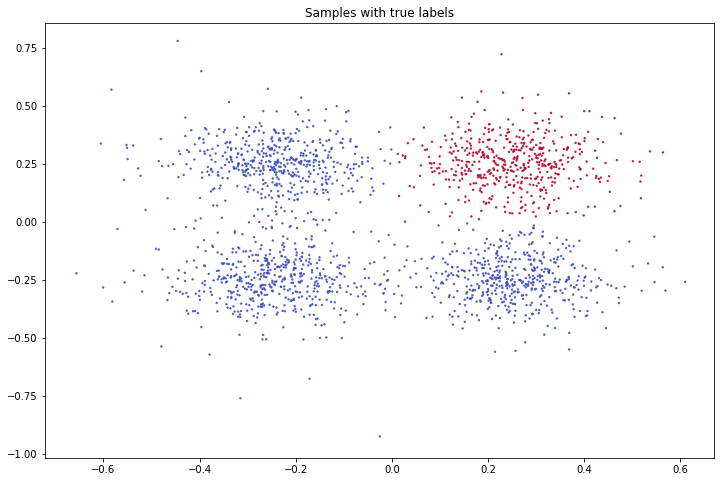

In [34]:
and_gate_pipeline.plot_data(
    figsize=figsize, xlim=[x_min[0], x_max[0]], ylim=[x_min[1], x_max[1]])


In [35]:
# 80:20 split on training and test sets
and_gate_pipeline.train_test_split(0.2)

Train test split: 0.80:0.20


In [36]:
and_gate_pipeline.fit_svm_model(gamma=gamma, C=C, shift=shift)


With gamma = scale and C = 100
Accuracy on train set = 100.0000%
Accuracy on test set  = 99.7500%
Passed basic test


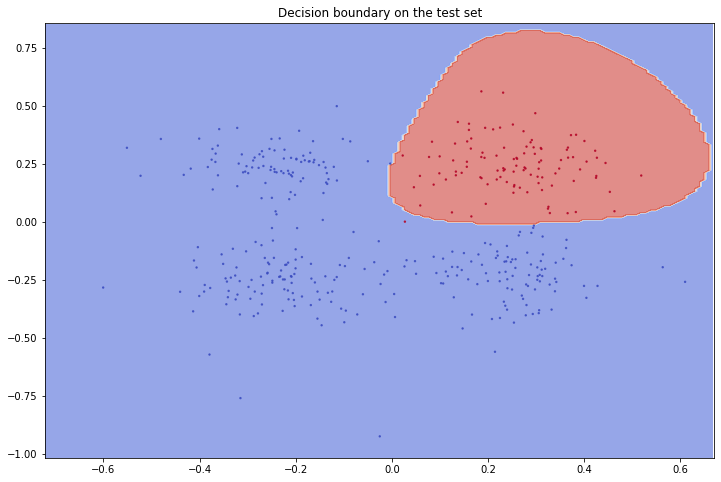

In [37]:
and_gate_pipeline.plot_prediction(
    figsize, h=0.01, 
    mesh_xlim=[x_min[0], x_max[0]], mesh_ylim=[x_min[1], x_max[1]], 
    xlim=[x_min[0], x_max[0]], ylim=[x_min[1], x_max[1]])


In [38]:
and_gate_pipeline.model.get_params()


{'C': 100,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 4096,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [39]:
and_gate_pipeline.generate_adversarial_examples(epsilon=0.0006)


Negative mean = [-0.0848, -0.0740]
Positive mean = [0.2498, 0.2561]
Completed after 1527 epoch...
Misclassified = 292
Misclassified negative = 66 (16.5000%)
Misclassified positive = 226 (56.5000%)
Found 292 Adversarial Examples out of 400. 73.0000% successful rate


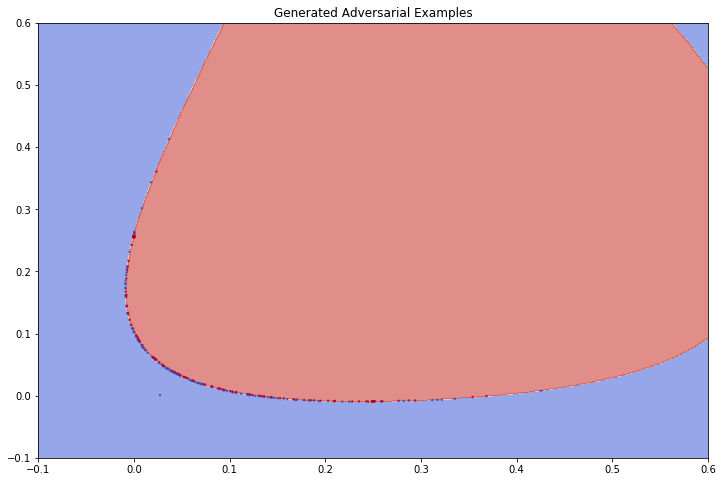

In [40]:
and_gate_pipeline.plot_adversarial_examples(
    figsize, h=0.001,
    mesh_xlim=[-0.1, 0.6], mesh_ylim=[-0.1, 0.6],
    xlim=[-0.1, 0.6], ylim=[-0.1, 0.6])


In [41]:
and_gate_pipeline.run_applicability_domain(zeta0=zeta0, zeta1=zeta1, k=k)



---------- Applicability ---------------
Pass rate = 100.0000%

---------- Reliability -----------------

In 0 class:
Threshold = 0.0758
Average mean = 0.0841
Passed indices:
5, 7, 29, 42, 44, 54, 55, 61, 77, 79, 86, 92, 96, 115, 126, 132, 134, 136, 161, 164, 176, 188, 190, 197, 199, 214, 222, 237, 255, 281, 287, 288, 310, 332, 333, 339, 346, 347, 352, 353, 365, 371, 379, 394

In 1 class:
Threshold = 0.0588
Average mean = 0.0696
Passed indices:
0, 1, 12, 24, 26, 33, 37, 41, 52, 53, 56, 59, 62, 75, 76, 83, 89, 90, 91, 95, 99, 100, 112, 117, 125, 144, 145, 147, 155, 156, 160, 168, 171, 174, 178, 181, 183, 187, 193, 198, 200, 201, 203, 209, 210, 220, 221, 224, 236, 243, 245, 250, 252, 254, 257, 264, 266, 268, 269, 270, 271, 272, 273, 279, 285, 295, 296, 299, 308, 314, 318, 324, 326, 328, 331, 341, 343, 344, 362, 372, 376, 377, 384, 385, 389, 393, 398
Distance of c0 in training set:
Mean               = 0.0281
Standard deviation = 0.0217
Threshold          = 0.0758

Distance of c1 in trai

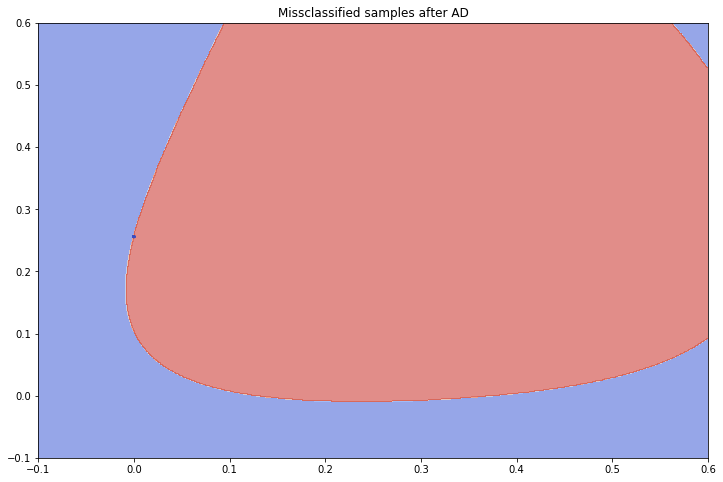

In [42]:
and_gate_pipeline.plot_after_ad(
    figsize, h=0.001,
    mesh_xlim=[-0.1, 0.6], mesh_ylim=[-0.1, 0.6],
    xlim=[-0.1, 0.6], ylim=[-0.1, 0.6])
